# Machine Learning Assignment Project: Taxi Duration in New York City Prediction - A Comprehensive Analysis with Machine Learning Techniques

In [5]:
# Import libraries
import os, shutil
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

## Import dataset

In [6]:
# Check kaggle if it's available
!kaggle --version

Kaggle API 1.7.4.5


### Download dataset from kaggle

In [7]:
#!kaggle competitions download -c nyc-taxi-trip-duration -p ./data

### Unzip files

In [8]:
# Unzip the downloaded file
def unzip_file(zip_src, dst_dir, delete=False):
    if os.path.exists(zip_src) and zip_src.endswith(".zip"):
        with zipfile.ZipFile(zip_src, 'r') as zf:
            zf.extractall(dst_dir)
    else:
        print(f"The address of file is {zip_src}, which isn't support upzipping.")
        return
        
    # remove the zip file after extraction
    if delete:
        os.remove(zip_src)
        print(f"Deleted: {zip_src}")

#### Unzipping parent directory

In [9]:
data_dir = "./data"
zip_name = "nyc-taxi-trip-duration.zip" 
unzip_file(os.path.join(data_dir, zip_name), data_dir, True)
!ls ./data

The address of file is ./data/nyc-taxi-trip-duration.zip, which isn't support upzipping.


ls: cannot access './data': No such file or directory


#### Unzipping main files

In [11]:
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    if os.path.isfile(file_path) and filename.endswith(".zip") and filename != "sample_submission.zip":
        unzip_file(file_path, data_dir, delete=True)

In [12]:
!ls ./data

sample_submission.zip  test.csv  titanic_old  train.csv


### Load dataset into DataFrame

In [13]:
df = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
print(df.shape)
print(df.info())
print(df.isnull().sum())
df.head(5)

(1458644, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude     

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


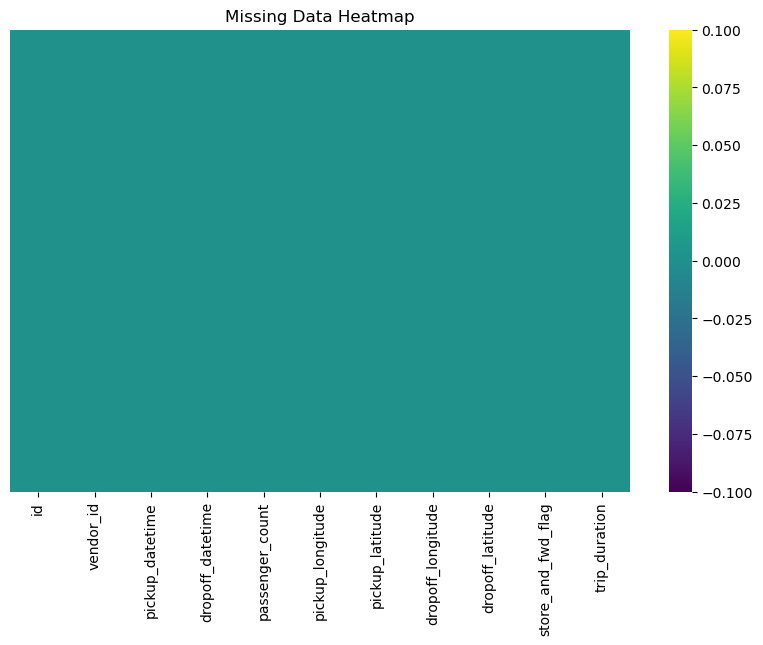

In [14]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

Our dataset isn't contain any null values, so we can proceed with our analysis.

## Preprocessing data

### Define the haversine distance function

In [15]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6378.137 # Earth radius in kilometres
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    return R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

In [ ]:
def distance(df: pd.DataFrame) -> pd.DataFrame:
    df['distance_km'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )

    return df

### Define feature engineering functions

In [17]:
def feature_engineering(df):
    df = df.copy()

    # Time
    pickup_datetime = pd.to_datetime(df['pickup_datetime'])
    df['pickup_year'] = pickup_datetime.dt.year
    df['pickup_month'] = pickup_datetime.dt.month
    df['pickup_day'] = pickup_datetime.dt.day
    df['pickup_hour'] = pickup_datetime.dt.hour
    df['pickup_minute'] = pickup_datetime.dt.minute
    df['pickup_weekday'] = pickup_datetime.dt.weekday
    df['pickup_yday'] = pickup_datetime.dt.dayofyear
    df['pickup_weekend'] = (pickup_datetime.dt.weekday >= 5).astype(int)

    # Time category
    df['is_rush_hour'] = (((df['pickup_hour'] >= 7) & (df['pickup_hour'] <= 9)) |
                          ((df['pickup_hour'] >= 17) & (df['pickup_hour'] <= 19))).astype(int)
    df['is_night'] = ((df['pickup_hour'] >= 22) | (df['pickup_hour'] <= 5)).astype(int)

    # Calculate the distance with Haversine fomula
    df['distance_km'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )

    df['direction'] = np.degrees(np.arctan2(
        (df['dropoff_latitude'] - df['pickup_latitude']),
        (df['dropoff_longitude'] - df['pickup_longitude'])
    ))

    # Center coordinates
    df['center_latitude'] = (df['pickup_latitude'] + df['dropoff_latitude']) / 2
    df['center_longitude'] = (df['pickup_longitude'] + df['dropoff_longitude']) / 2

    # Binary categorical
    df['store_and_fwd_flag'] = (df['store_and_fwd_flag'] == 'Y').astype(int)

    return df


### Clean data formatting and outlier removal

In [18]:
def clean_data(df):
    df = df.copy()

    print(f"Initial shape: {df.shape}")

    if 'trip_duration' in df.columns:
        df = df[(df['trip_duration'] > 30) & (df['trip_duration'] < 3600 * 6)]
        print(f"After duration filter: {df.shape}")

    # Remove zero-distance trips
    df = df[df['distance_km'] > 0]
    print(f"After distance filter: {df.shape}")

    # Geographic bounding box
    bounds = {'min_lat': 40.5, 'max_lat': 41.0, 'min_lon': -74.3, 'max_lon': -73.7}
    df = df[
        (df['pickup_latitude'].between(bounds['min_lat'], bounds['max_lat'])) &
        (df['pickup_longitude'].between(bounds['min_lon'], bounds['max_lon'])) &
        (df['dropoff_latitude'].between(bounds['min_lat'], bounds['max_lat'])) &
        (df['dropoff_longitude'].between(bounds['min_lon'], bounds['max_lon']))
    ]

    print(f"After geographic filter: {df.shape}")
    return df

### Preprocessing function

In [22]:
def preprocessing(df: pd.DataFrame, scale=True, random_state=42) -> tuple:
    
    # Geospatial feature engineering
    df = feature_engineering(df)
    
    # Data cleaning
    df = clean_data(df)

    # Target transformation
    y = np.log1p(df['trip_duration'])  # log-transform to handle skewness

    # Drop unused columns
    drop_cols = ['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration']
    X = df.drop(columns=[c for c in drop_cols if c in df.columns])
    

    # Split dataset into train, test, val sets with the ratio: ()
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

    # Feature scaling
    scaler = None
    if scale:
        numerical_cols = [
            'vendor_id', 'passenger_count',
            'pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'pickup_hour', 'pickup_weekday', 'pickup_month',
            'distance_km', 'direction',
            'center_latitude', 'center_longitude'
        ]

        # Only scale columns that exist
        numerical_cols = [col for col in numerical_cols if col in X_train.columns]

        scaler = StandardScaler()
        X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
        X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
        X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    print("Preprocessing completed.")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

## Apply preprocessing function to the dataset

In [23]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocessing(df)

Initial shape: (1458644, 25)
After duration filter: (1451693, 25)
After distance filter: (1447148, 25)
After geographic filter: (1446308, 25)
Preprocessing completed.
Train: (1157046, 21), Val: (144631, 21), Test: (144631, 21)


## Dump the scaler.pkl file for future use in web app

In [26]:
import pickle
import os

X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocessing(df, scale=True)
atf_path = "../" + "artifacts"
os.makedirs(atf_path, exist_ok=True)
scaler_path = os.path.join(atf_path, 'scaler.pkl')
if scaler is not None:
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Saved scaler.pkl at {scaler_path}")
else:
    print("Cannot save")

Initial shape: (1458644, 25)
After duration filter: (1451693, 25)
After distance filter: (1447148, 25)
After geographic filter: (1446308, 25)
Preprocessing completed.
Train: (1157046, 21), Val: (144631, 21), Test: (144631, 21)
Saved scaler.pkl at ../artifacts/scaler.pkl


In [27]:
# Show first 5 rows of processed training data
print("Processed training features:")
print(X_train.head())

print("\nProcessed training target:")
print(y_train.head())

Processed training features:
         vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
639188    0.933769        -0.505563          0.524444         1.105149   
368146    0.933769         1.016558         -0.959225        -1.625605   
855622   -1.070929        -0.505563         -0.043205         0.179363   
1151270  -1.070929        -0.505563         -0.232286        -0.044750   
173902    0.933769        -0.505563         -0.323483         0.401694   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  pickup_year  \
639188           -0.131055          0.458424                   0         2016   
368146           -0.063123         -0.678279                   0         2016   
855622           -0.276625          0.096165                   0         2016   
1151270           0.216107          1.653890                   0         2016   
173902           -0.552987         -0.474157                   0         2016   

         pickup_month  pickup_day  ... 

### Visualize key distributions and correlations after preprocessing

In [28]:
def visualize_processed_data(X_train, y_train):
    # Reverse log-transform for interpretation
    trip_duration_original = np.expm1(y_train)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # Trip duration distribution
    sns.histplot(trip_duration_original, bins=50, kde=True, color='teal', ax=axes[0, 0])
    axes[0, 0].set_title("Distribution of Trip Duration (seconds)")
    axes[0, 0].set_xlabel("Trip Duration (s)")
    axes[0, 0].set_ylabel("Frequency")

    # Distance distribution
    if 'distance_km' in X_train.columns:
        sns.histplot(X_train['distance_km'], bins=50, kde=True, color='orange', ax=axes[0, 1])
        axes[0, 1].set_title("Distribution of Trip Distance (km)")
        axes[0, 1].set_xlabel("Distance (km)")
        axes[0, 1].set_ylabel("Frequency")

    # Trip duration by pickup hour
    if 'pickup_hour' in X_train.columns:
        sns.boxplot(x=X_train['pickup_hour'], y=trip_duration_original, ax=axes[1, 0], color='lightblue')
        axes[1, 0].set_title("Trip Duration by Pickup Hour")
        axes[1, 0].set_xlabel("Hour of Day")
        axes[1, 0].set_ylabel("Trip Duration (s)")

    # Correlation heatmap
    corr = X_train.drop(columns=['vendor_id'], errors='ignore').corr(numeric_only=True)
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, ax=axes[1, 1])
    axes[1, 1].set_title("Feature Correlation Heatmap")

    plt.show()

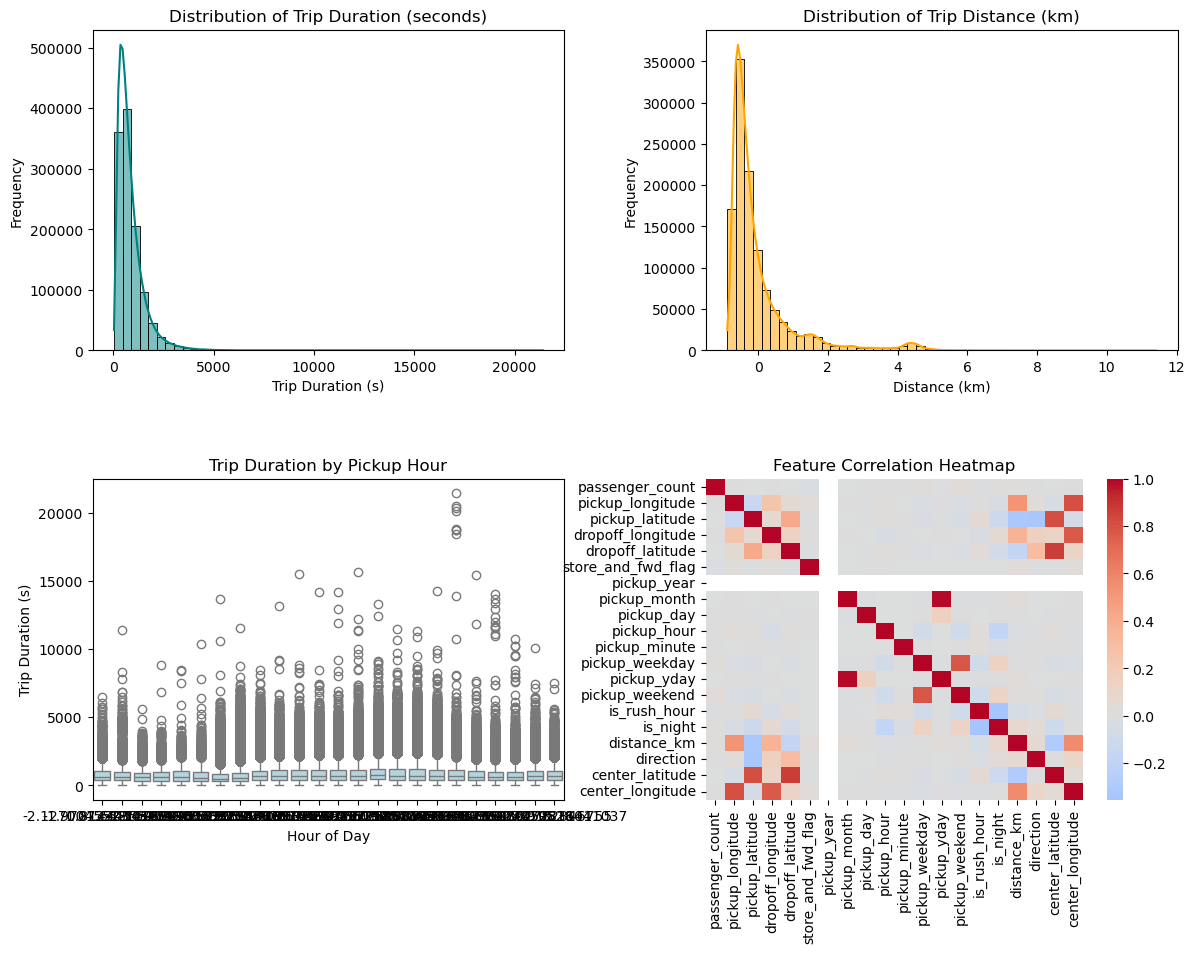

In [29]:
visualize_processed_data(X_train, y_train)

### Training Model 

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

# Dự đoán
y_pred_val = lr.predict(X_val)
y_pred_test = lr.predict(X_test)

# Đánh giá trên validation
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred_val)))
mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_val))
r2 = r2_score(y_val, y_pred_val)
mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred_val))

print("=== Baseline Model: Linear Regression ===")
print(f"RMSLE: {rmsle:.4f}")
print(f"MAE: {mae:.2f} seconds")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

NameError: name 'X_train' is not defined

In [ ]:
# ==================== IMPORTS ====================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def rmsle_cv(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmsle_scorer = make_scorer(rmsle_cv, greater_is_better=False)

def generate_baseline_results_regression(
    models, X, y_log, metric='rmsle_fast', cv=3, plot_results=True, n_jobs=-1, sample_frac=0.2
):

    if isinstance(X, pd.DataFrame) and isinstance(y_log, (pd.Series, pd.DataFrame)):
        if not X.index.equals(y_log.index):
            print("Aligning X and y_log by index...")
            X, y_log = X.align(y_log, join='inner', axis=0)

    # Subsample
    if sample_frac < 1.0:
        n_samples = int(len(X) * sample_frac)
        sample_indices = np.random.choice(X.index, size=n_samples, replace=False)
        X_sample = X.loc[sample_indices]
        y_sample_log = y_log.loc[sample_indices] if hasattr(y_log, 'loc') else y_log[sample_indices]
        print(f"Subsampled: {len(X)} → {len(X_sample)} ({sample_frac:.0%})")
    else:
        X_sample = X
        y_sample_log = y_log

    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    entries = []

    print("Running cross-validation...")
    for model in models:
        model_name = model.__class__.__name__
        print(f"  → {model_name}", end="")
        scores = cross_val_score(model, X_sample, y_sample_log, scoring=rmsle_scorer, cv=kfold, n_jobs=n_jobs)
        mean_rmsle = np.mean(-scores)
        std_rmsle = np.std(-scores)
        print(f" [DONE] RMSLE: {mean_rmsle:.4f} ± {std_rmsle:.4f}")
        for fold_idx, s in enumerate(scores):
            entries.append((model_name, fold_idx, s))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_id', 'rmsle'])
    results = cv_df.groupby('model_name')['rmsle'].agg(['mean', 'std']).round(5)
    results = results.sort_values(by='mean', ascending=True)

    if plot_results:
        plt.figure(figsize=(9, 5))

        ax = sns.barplot(
            data=results.reset_index(),
            x='model_name', y='mean',
            errorbar='sd',
            capsize=0.2, palette='viridis'
        )

        plt.title(f"Baseline (RMSLE) - Sample {sample_frac:.0%} | CV={cv}")
        plt.ylabel("RMSLE (log scale)")
        plt.xlabel("Model")
        plt.xticks(rotation=30, ha='right')

        for i, row in enumerate(results.itertuples()):
            ax.text(i, row.mean + row.std + 0.0005,
                    f"{row.mean:.4f}±{row.std:.4f}",
                    ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

        plt.tight_layout()
        plt.show()

    return results

# Đảm bảo X_train và y_train có cùng index
print(f"X_train shape: {X_train.shape}, y_train length: {len(y_train)}")
if isinstance(X_train, pd.DataFrame) and isinstance(y_train, pd.Series):
    if not X_train.index.equals(y_train.index):
        print("Resetting index để đồng bộ...")
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)

# Log transform
y_train_log = np.log1p(y_train)

models = [
    LinearRegression(n_jobs=-1),
    DecisionTreeRegressor(max_depth=12, random_state=42),
    RandomForestRegressor(n_estimators=50, max_depth=12, n_jobs=-1, random_state=42),
    XGBRegressor(n_estimators=50, max_depth=6, n_jobs=-1, tree_method='hist', random_state=42, verbosity=0)
]

baseline_results = generate_baseline_results_regression(
    models=models,
    X=X_train,
    y_log=y_train_log,
    cv=3,
    n_jobs=-1,
    sample_frac=0.2,  # 20% dữ liệu
    plot_results=True
)

print("\nKẾT QUẢ BASELINE:")
print(baseline_results)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
import numpy as np

# Custom RMSLE scorer
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Mô hình
xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.3, 0.5]
}

# Randomized search
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20, # 20 tổ hợp ngẫu nhiên
    scoring=rmsle_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
print("\nBest RMSLE:", -search.best_score_)
print("Best params:", search.best_params_)


In [ ]:
def clean_data_not_drop(df, is_train=True):
    df = df.copy()
    print(f"Initial shape: {df.shape}")

    if is_train and 'trip_duration' in df.columns:
        df = df[(df['trip_duration'] > 30) & (df['trip_duration'] < 3600 * 6)]
        print(f"After duration filter: {df.shape}")

    if is_train:
        df = df[df['distance_km'] > 0]
        print(f"After distance filter: {df.shape}")
    else:
        df.loc[df['distance_km'] <= 0, 'distance_km'] = 0.1

    bounds = {'min_lat': 40.5, 'max_lat': 41.0, 'min_lon': -74.3, 'max_lon': -73.7}
    if is_train:
        df = df[
            (df['pickup_latitude'].between(bounds['min_lat'], bounds['max_lat'])) &
            (df['pickup_longitude'].between(bounds['min_lon'], bounds['max_lon'])) &
            (df['dropoff_latitude'].between(bounds['min_lat'], bounds['max_lat'])) &
            (df['dropoff_longitude'].between(bounds['min_lon'], bounds['max_lon']))
        ]
        print(f"After geographic filter: {df.shape}")
    else:
        df['pickup_latitude'] = df['pickup_latitude'].clip(bounds['min_lat'], bounds['max_lat'])
        df['pickup_longitude'] = df['pickup_longitude'].clip(bounds['min_lon'], bounds['max_lon'])
        df['dropoff_latitude'] = df['dropoff_latitude'].clip(bounds['min_lat'], bounds['max_lat'])
        df['dropoff_longitude'] = df['dropoff_longitude'].clip(bounds['min_lon'], bounds['max_lon'])

    print(f"After cleaning ({'train' if is_train else 'test'}): {df.shape}")
    return df


In [ ]:
test_processed = feature_engineering(test)
test_processed = clean_data_not_drop(test_processed, is_train=False)

test_id = test_processed["id"]

drop_cols = ['id', 'pickup_datetime', 'dropoff_datetime']
X_submit = test_processed.drop(columns=[c for c in drop_cols if c in test_processed.columns], errors='ignore')

numerical_cols = [
    'vendor_id', 'passenger_count',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'pickup_hour', 'pickup_weekday', 'pickup_month',
    'distance_km', 'direction',
    'center_latitude', 'center_longitude'
]
numerical_cols = [c for c in numerical_cols if c in X_submit.columns]
X_submit[numerical_cols] = scaler.transform(X_submit[numerical_cols])

# 6️⃣ Dự đoán
best_model = search.best_estimator_
y_pred = best_model.predict(X_submit)
y_pred = np.expm1(y_pred)

submission = pd.DataFrame({
    "id": test_id,
    "trip_duration": y_pred
})
submission.to_csv("submission.csv", index=False)
print("File submission.csv đã được tạo thành công!")
